In [141]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 

Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)

b = []

for i in range (1000):
    data = run(['curl', ('http://togows.org/api/ucsc/hg19/'+ str(Data['chromosome'][i])+':'+str(int(Data["Primary TSS, 5'"][i]-1000))+'-'+str(Data["Primary TSS, 5'"][i]+1000)+'.fasta/')], stdout=PIPE, stderr=PIPE, universal_newlines=True).stdout[:].replace('\n','')    
    b.append(data)
    if i % 1000 == 0: print(i)
    
#It took 106 minutes to comlpete all the sequences for 2.5 kb 

# 17 min for current states on 3000 only
#6000 took 36.15 min

0


### 1. Data Pre-processing

In [388]:
Promoter_sequences = pd.DataFrame(b)

# Get all permutations of [1, 2, 3]
perm = ['A','C','G','T']
nucleotides = []

for p in range(1):
    for i in list(perm):
            for x in range(10):
                temp = '%s%s' % (x, i)
                nucleotides.append(temp)
    for z in range(len(Promoter_sequences)):
            for h in list(nucleotides):
                Promoter_sequences[0][z] = Promoter_sequences[0][z].replace(h,str((h[0],h[1])))
            if z % 1000 == 0:
                print(z)

Promoter_sequences[0] = Promoter_sequences[0].str.replace("'", "").str.replace(" ", "").str.replace("(", "").str.replace(")", "").str.replace(">hg19:", "")
Promoter_sequences = Promoter_sequences[0].str.split(",", expand = True)

0


Here you can select the length of the kmers used in the model

In [389]:
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

Promoter_sequences[2] = Promoter_sequences.apply(lambda x: getKmers(x[1], 3), axis = 1)
Promoter_sequences = Promoter_sequences.drop(1, axis =1 )
Promoter_sequences = Promoter_sequences.drop(0, axis =1 )

Promoter_sequences[3] =  pd.DataFrame([1 if x != '[]' else 0 for x in Data['CpG_location']])

The Scikit-learn library natural language processing tools do the k-mer counting. Here we convert the list into strings, which then get vectorized. The y variable will hold the class labels.

In [390]:
Promoters_text = list(Promoter_sequences[2])
for item in range(len(Promoters_text)):
    Promoters_text[item] = ' '.join(Promoters_text[item])
y_data = Promoter_sequences.iloc[:, 1].values                         

This is the Bag-of-words technique for natural language processing of text modelling.

In [391]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
#cv = CountVectorizer(ngram_range=(3,100))
X = cv.fit_transform(Promoters_text)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size = 0.20, random_state=42)

print(X.shape)

(1000, 64)


Here we graph the correspondent data of each of the Promoter sequences

<AxesSubplot:>

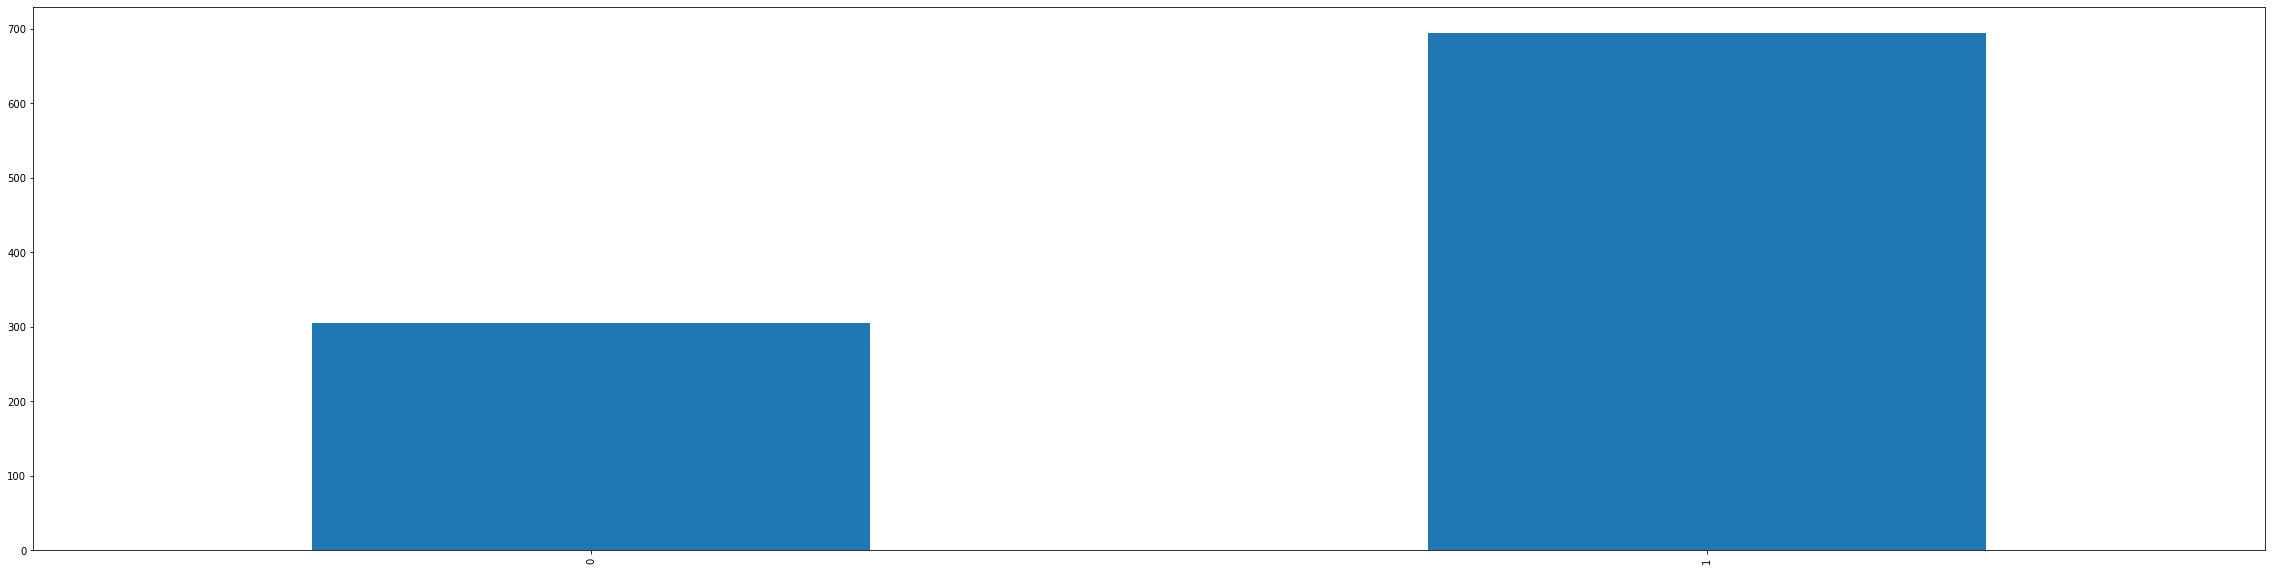

In [392]:
Promoter_sequences[3].value_counts().sort_index().plot.bar()

### 2. Multinomial Naive Bayes Model 

Here, the multinomal naive bayes classifier is used. More information at https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [393]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

Prediction:

In [394]:
y_pred = classifier.predict(X_test)

Confusion Matrix: 

In [395]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1
Actual            
0          48    9
1          16  127
accuracy = 0.875 
precision = 0.881 
recall = 0.875 
f1 = 0.877


We can also graph the score for each of the combinations of letter, and compare significance.

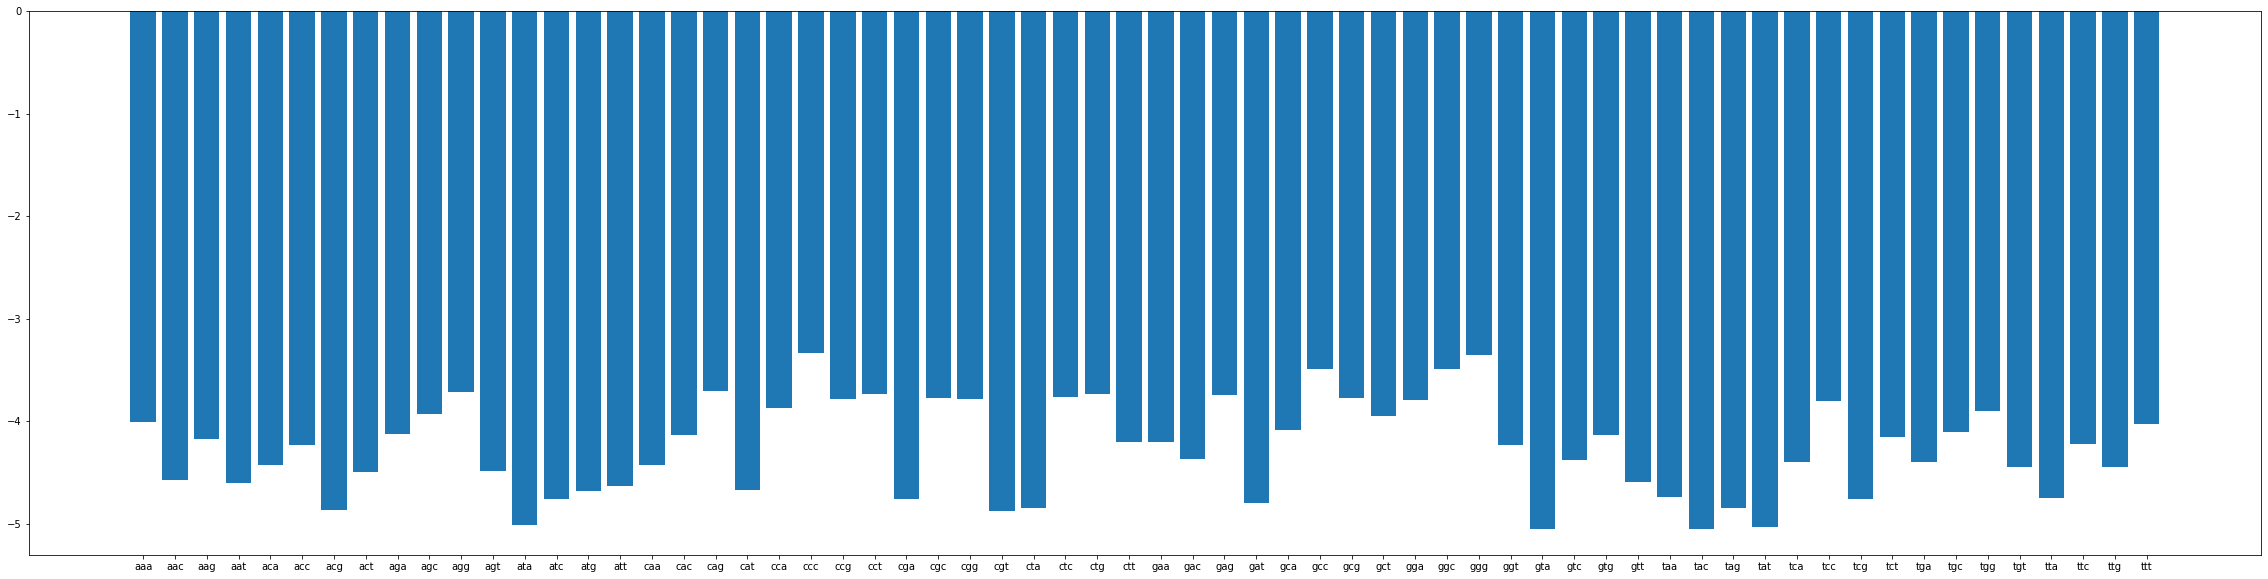

In [422]:
import matplotlib.pyplot as plt

weights = pd.DataFrame([cv.get_feature_names(), classifier.coef_[0]]).T
weights.sort_values(by = 1)

plt.bar(weights[0],weights[1])
plt.rcParams["figure.figsize"] = (40,10)
plt.show()

In [525]:
len(Promoters_text.seq[0])

7995

### 3. Genism word2vec Model Training

Genism, a Natural Language Processing Library for the Word2Vec algorithm

Adapted from https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

In [550]:
import gensim
from gensim.utils import simple_preprocess
Promoters_text = pd.DataFrame(Promoters_text, columns=['seq'])
Review_text = Promoters_text.seq.apply(simple_preprocess)

from gensim.models import Word2Vec

model = Word2Vec(vector_size = 7995)
model.build_vocab(Review_text, progress_per=3)
model.train(Review_text, total_examples=model.corpus_count, epochs = model.epochs)

(3119246, 9995000)

In [551]:
from gensim.models import KeyedVectors

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

**size:** The number of dimensions of the embeddings and the default is 100.

**window:** The maximum distance between a target word and words around the target word. The default window is 5.

**min_count:** The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.

**workers:** The number of partitions during training and the default workers is 3.

**sg:** The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

After training the word2vec model, we can obtain the word embedding directly from the training model as following.

### 4. Compute Similarities

In [399]:
model.wv.most_similar('cgc')
model.wv.similarity(w1 = "ccc", w2 = 'aaa')

-0.43508375

However, Euclidian similarity cannot work well for the high-dimensional word vectors. This is because Euclidian similarity will increase as the number of dimensions increases, even if the word embedding stands for different meanings. Alternatively, we can use cosine similarity to measure the similarity between two vectors. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity captures the angle of the word vectors and not the magnitude. Under cosine similarity, no similarity is expressed as a 90-degree angle while the total similarity of 1 is at a 0-degree angle.

In [409]:
from numpy import dot
from numpy.linalg import norm

Promoter_sequences.columns = ['seq', 'cpgs']

def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]
    
cosine_distance (model.wv,'cgc', Promoter_sequences.seq[1], 10)

[('cgg', 0.7520449),
 ('ggc', 0.56976336),
 ('cga', 0.5633306),
 ('ccc', 0.5489363),
 ('cgt', 0.5317842),
 ('gcc', 0.48759094),
 ('ccg', 0.47387692),
 ('gcg', 0.3623014),
 ('agc', 0.34399384),
 ('tgc', 0.3184208)]

### 5. T-SNE Visualizations

It’s hard to visualize the word embedding directly, for they usually have more than 3 dimensions. T-SNE is a useful tool to visualize high-dimensional data by dimension reduction while keeping relative pairwise distance between points. It can be said that T-SNE looking for a new data representation where the neighborhood relations are preserved. The following code shows how to plot the word embedding with T-SNE plot.

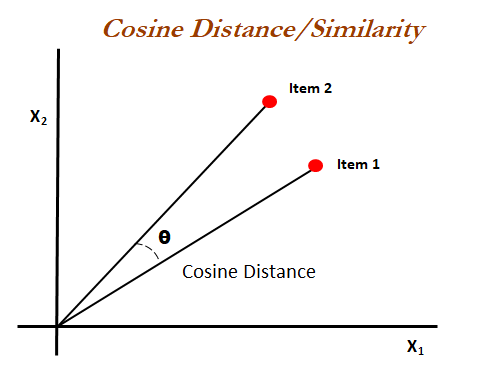

In [448]:
from IPython.display import Image
Image("https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/assets/2b4a7a82-ad4c-4b2a-b808-e423a334de6f.png")

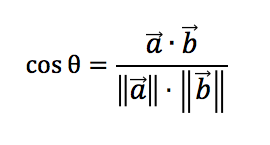

In [446]:
Image("https://sites.temple.edu/tudsc/files/2017/03/cosine-equation.png")

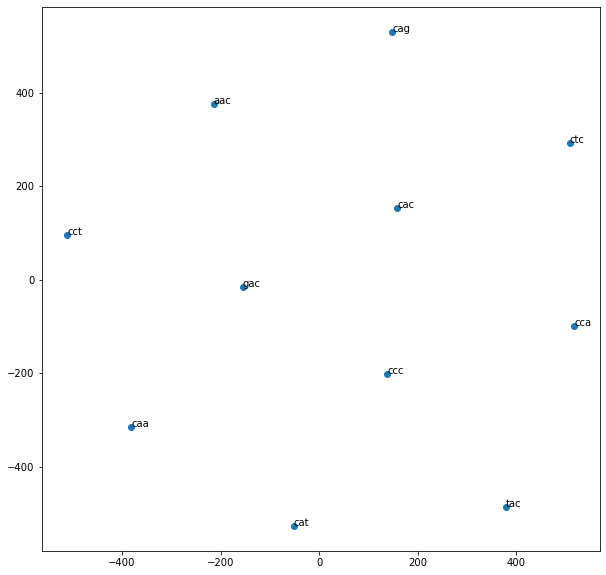

In [451]:
from sklearn.manifold import TSNE
from matplotlib import figure
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

def display_closestwords_tsnescatterplot(model, word, size):
        
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)

    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
        tsne = TSNE(n_components=2, random_state=0)
        np.set_printoptions(suppress=True)
        Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
            #plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
            #plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    
    plt.rcParams["figure.figsize"] = (10,10)
    plt.show()

display_closestwords_tsnescatterplot(model.wv, 'cac', 100) 

### 6. K-fold Cross-Validation in Keras Convolutional Neural Networks

Adapted from https://github.com/juanmangh/FrenchCandidateSpeechAnalysis/blob/master/Speech%20Analysis%20French%20Presidential%20Campaign%202017.ipynb

In [552]:
from keras.datasets import reuters
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, MaxPooling1D, Convolution1D, Embedding
from keras.utils import np_utils
from keras.layers.merge import Concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [584]:
dropout_prob = (0.5, 0.8)

input_shape = (7995,)
model_input = Input(shape=input_shape)

In [585]:
conv_blocks = []
z = Embedding(model.vector_size, 7995, input_length=3, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

In [586]:
conv = Convolution1D(filters=300,
                     kernel_size=3,
                     padding="valid",
                     activation="relu",
                     strides=1)(z)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Flatten()(conv)
conv_blocks.append(conv)

conv = Convolution1D(filters=300,
                     kernel_size=3,
                     padding="valid",
                     activation="relu",
                     strides=1)(z)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Flatten()(conv)
conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(50, activation="relu")(z)
model_output = Dense(6, activation="sigmoid")(z)

model1 = Model(model_input, model_output)
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model1.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 7995)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 7995, 7995)   63920025    input_12[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 7995, 7995)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 7993, 300)    7195800     dropout_15[0][0]                 
___________________________________________________________________________________________

In [579]:
model1.fit(Promoter_sequences[2], Promoter_sequences.cpgs, shuffle=True,batch_size=64, epochs=10, verbose=1)

KeyError: 2